In [1]:
%matplotlib inline
import numpy as np
import json
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from misc.data_loader import CDATA
from misc.image_embedding import ImageEmbedding
from misc.question_embedding import QuestionEmbedding
from misc.san import Attention
import misc.utils 
from misc.utils import *

from PIL import Image
from matplotlib import pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
print("constructing test dataset...")

opt = {'feature_type': 'VGG', 
       'img_feature_path': './data', 
       'h5_ques_file': './data/vqa_data_prepro.hdf5', 
       'json_file': './data/vqa_ques_prepro.json',
       'txt_json_path': './data/vqa_txt_data_prepro.json'}

test_dataset = CDATA(opt, train=True, quiet=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=50, shuffle=False)

print('finished.')

constructing test dataset...
finished.


In [4]:
print("constructing nn models...")

vocab_size = test_dataset.getVocabSize()

question_model = QuestionEmbedding(vocab_size=test_dataset.getVocabSize(), 
                                   emb_size=500, hidden_size=1024, use_gpu=True, 
                                   dict_json_path='./data/vqa_ques_prepro.json', 
                                   num_layers=1, dropout=0.5)

image_model = ImageEmbedding(hidden_size=1024, use_gpu=True, feature_type='VGG')

attention_model = Attention(input_size=1024, att_size=512, img_seq_size=196, 
                            output_size=6, drop_ratio=0.5)
    
question_model.to(device)
image_model.to(device)
attention_model.to(device)

question_model.load_state_dict(torch.load(os.path.join('./train_model/vgg_method1_output6_model/'
                                                       'question_model.pkl')),
                               strict=False)

image_model.load_state_dict(torch.load(os.path.join('./train_model/vgg_method1_output6_model/'
                                                    'image_model.pkl')), 
                            strict=False)

attention_model.load_state_dict(torch.load(os.path.join('./train_model/vgg_method1_output6_model/'
                                                        'attention_model.pkl')), 
                                strict=False)

print('finished.')

constructing nn models...


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


finished.


In [5]:
img_dict = open('./data/image_path_output.json', encoding='utf-8')
img_dict = json.load(img_dict)
img_list = [w + '.jpg' for w in list(img_dict['img_path_train'].values())]

txt_dict = open('./data/vqa_txt_data_prepro.json', encoding='utf-8')
txt_dict = json.load(txt_dict)
ques_list = txt_dict['raw_ques_train']
ans_list = txt_dict['raw_mc_ans_train']

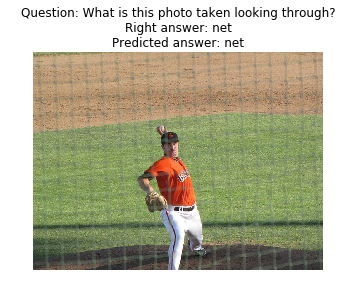

In [6]:
img = Image.open('/datasets/ee285f-public/VQA2017/'+img_list[0]).convert('RGB')

image, question, answer = test_dataset[0]
image = torch.from_numpy(image).unsqueeze(0)
question = torch.from_numpy(question).unsqueeze(0)
answer = torch.from_numpy(answer)

image = Variable(image, requires_grad=False).to(device)
question = Variable(question, requires_grad=False).to(device)

img_emb = image_model(image)
ques_emb = question_model(question, 1)
output = attention_model(ques_emb, img_emb)

weights = torch.softmax(output, 1)
prediction = torch.argmax(weights, 1)

if prediction < len(ans_list[0]):
    plt.imshow(img)
    plt.axis('off')
    plt.title('Question: {}\nRight answer: {}\nPredicted answer: {}'
              .format(ques_list[0], ans_list[0][answer], ans_list[0][prediction]))
    plt.show()